### Starting with the LSTM model ... 

File initially created 5/28/2025. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

#tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-04 18:39:49.072414: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 18:39:49.103237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-04 18:39:49.103258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-04 18:39:49.104207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 18:39:49.109222: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.15.0


In [3]:
from EOF_def import EOF_def

In [4]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [5]:
# load input solvers
infile = open("../../eof_analysis/solvers/Usolver_14.p","rb",)
Usolver = pickle.load(infile)  ##pv on an isentropic surface, 350
infile.close()

infile = open("../../eof_analysis/solvers/EHFsolver_14.p","rb",)
EHFsolver = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../eof_analysis/solvers/GPHsolver_14.p","rb",)
GPHsolver = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

In [6]:
## U
U_EOF_nw, U_EOF_nw2d, U_eigenv, U_VarEx, U_PC = EOF_def(Usolver, 10)

<class 'numpy.ndarray'> (8370, 10)


In [7]:
## EHF
EHF_EOF_nw, EHF_EOF_nw2d, EHF_eigenv, EHF_VarEx, EHF_PC = EOF_def(EHFsolver, 45)

<class 'numpy.ndarray'> (8370, 45)


In [8]:
## GPH
GPH_EOF_nw, GPH_EOF_nw2d, GPH_eigenv, GPH_VarEx, GPH_PC = EOF_def(GPHsolver, 10)

<class 'numpy.ndarray'> (8370, 10)


In [9]:
##remove PC 1
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

In [15]:
# load output data
infile = open("../../eof_data/old_temp/eur_anomtemps.p","rb",)
output = pickle.load(infile) 
infile.close()

In [16]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=1) 

In [17]:
##make pandas dataframe for RF
input = pd.DataFrame(inputvar)
input

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.771931,-1.799955,1.313722,-1.630033,0.566290,1.589922,-0.172617,1.566368,0.659295,0.199667,...,-0.379306,1.641585,-0.743088,-0.070795,0.742423,0.454864,0.251855,0.795493,-0.417825,-1.029987
1,0.803999,-1.900528,1.245334,-1.692496,0.101666,2.042962,0.076518,1.506671,0.006843,0.238603,...,0.347120,1.752066,-0.985741,0.049346,0.764168,0.594407,0.432133,1.080915,-0.165571,-1.420320
2,0.872130,-2.032226,1.424598,-1.343837,0.161601,1.711995,0.503023,0.826614,-1.105172,0.270467,...,-0.585204,1.588777,-1.302961,0.097989,0.733291,0.651646,0.515277,0.912816,0.289325,-1.499576
3,0.867914,-2.054812,1.657540,-0.838510,0.746273,1.227320,0.679350,1.134812,-0.876215,0.232273,...,0.789144,1.273398,-1.416257,-0.048546,0.671334,0.746395,0.300846,0.709486,0.123002,-0.751547
4,0.787536,-2.011126,1.559197,-0.409157,1.239623,0.913107,0.641640,1.931937,-0.272880,0.127776,...,0.377190,1.043657,-1.369488,-0.219058,0.751703,1.057360,0.347496,0.404459,0.330464,0.215042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8365,0.415159,-0.170777,-0.531934,-0.397453,1.102362,-0.267771,0.062068,1.148350,-2.241040,0.180624,...,-0.535923,1.136943,-0.416174,0.562862,-0.354710,-0.763675,-0.224326,0.846225,-1.504478,-0.403197
8366,0.484640,-0.232514,-0.597377,0.039627,0.837373,-0.276658,0.205001,1.321532,-2.205615,0.232497,...,-0.670336,1.115493,-0.641672,0.649173,-0.423895,-0.589386,-0.034272,0.739777,-1.244535,-0.653119
8367,0.558206,-0.163820,-0.476075,0.480464,0.879917,-0.589342,-0.360315,1.203000,-2.164044,0.126000,...,-1.172690,0.839839,-1.031493,0.910849,-0.425116,-0.327954,0.842602,1.100344,-0.612106,-0.448852
8368,0.591930,0.343880,-0.538673,1.014618,0.200438,-0.391132,-0.570871,1.115725,-1.033758,0.161263,...,-0.749049,0.472475,-1.311037,0.590795,-0.424628,-0.503666,0.747163,1.328334,-0.101280,-0.280176


In [18]:
##need to change this based on lag 
## 14-days = [:, 47:]
## 20-days = [:, 53:]
## 30-days = [:, 63:]

## 14-days = [:, 43:] 10 day window rather than 14
## 20-days = [:, 49:]
## 30-days = [:, 59:]

temp = output.reshape(62, 182)
temp = temp[:, 43:]
temp.shape

(62, 139)

In [19]:
#selected indices
##Europe
#Index([1, 56, 0, 54, 9, 57, 55, 3, 26, 4], dtype='int64')

##Nova
#Index([1, 56, 0, 55, 2, 53, 54, 9, 4, 22], dtype='int64')

##South
#Index([1, 56, 54, 53, 55, 4, 3, 21, 14, 0], dtype='int64')

In [20]:
#create pd datafram of selected feature columns.

sele_ind_df = input[[1, 56, 0, 54, 9, 57, 55, 3, 26, 4]]

In [21]:
#look at new input array
sele_ind_df

,1,56,0,54,9,57,55,3,26,4
0,-1.799955,0.742423,0.771931,-0.743088,0.199667,0.454864,-0.070795,-1.630033,-0.122694,0.566290
1,-1.900528,0.764168,0.803999,-0.985741,0.238603,0.594407,0.049346,-1.692496,0.082215,0.101666
2,-2.032226,0.733291,0.872130,-1.302961,0.270467,0.651646,0.097989,-1.343837,-0.386993,0.161601
3,-2.054812,0.671334,0.867914,-1.416257,0.232273,0.746395,-0.048546,-0.838510,-0.053356,0.746273
4,-2.011126,0.751703,0.787536,-1.369488,0.127776,1.057360,-0.219058,-0.409157,-0.076462,1.239623
...,...,...,...,...,...,...,...,...,...,...
8365,-0.170777,-0.354710,0.415159,-0.416174,0.180624,-0.763675,0.562862,-0.397453,0.743680,1.102362
8366,-0.232514,-0.423895,0.484640,-0.641672,0.232497,-0.589386,0.649173,0.039627,0.477832,0.837373
8367,-0.163820,-0.425116,0.558206,-1.031493,0.126000,-0.327954,0.910849,0.480464,0.355288,0.879917
8368,0.343880,-0.424628,0.591930,-1.311037,0.161263,-0.503666,0.590795,1.014618,-0.274484,0.200438


In [22]:
#turn input array into (# samples, 14 days, 10 features)
sele_ind_data = sele_ind_df.values
sele_ind_data1 = sele_ind_data.reshape(62,135,10)

temp_flat = temp.flatten()

In [23]:
sele_ind_data.shape

(8370, 10)

In [24]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,126,10,10))
new_output = np.empty((62,126))

for i in range(0,62):
    for j in range(0,126):
        new_input[i,j,:,:] = sele_ind_data1[i,j:j+10,:]
        new_output[i,j] = temp[i,j]

In [25]:
new_input = np.array(new_input)
new_output = np.array(new_output)
print(new_input.shape)
print(new_output.shape)

(62, 126, 10, 10)
(62, 126)


In [26]:
frac_ind = round((62*126)*0.175)
frac_end = round((62*126)-frac_ind)
frac_end

6445

In [27]:
frac_ind

1367

In [28]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*126),10,10))
Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [29]:
Y_all.shape

(7812, 2)

In [30]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [31]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [32]:
##number of input nodes
numb_int = X_all.shape[1:]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [33]:
Y_train.shape

(5078, 2)

In [34]:
numb_int

(10, 10)

In [35]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.8352876}

### Model Architecture. 

In [36]:
######
batch_size = 64 #The number of samples the network sees before it backpropagates (batch size)
epochs = 30 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [37]:
def categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Cross-entropy loss
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Compute focal loss scaling factor
        focal_factor = tf.pow(1 - y_pred, gamma)
        loss = alpha * focal_factor * cross_entropy

        return tf.reduce_sum(loss, axis=1)  # sum across classes per sample

    return loss

In [39]:
#model
def basic_LSTM(ntimestep, nfeature, n1, n2, n3, rl1, rl3, lr):  
    input_tensor = Input(shape=(ntimestep, nfeature))
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          dropout=0.2, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=True)(input_tensor)
       
    layer2 = layers.RNN(
        layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)))(layer1)
    
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer2)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss=categorical_focal_loss(alpha=0.9, gamma=0.2),metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [40]:
model = basic_LSTM(numb_int[0],numb_int[1], 64, 16, 16, 0.208, 0.177, 0.0006466)

In [41]:
##create model
#model = basic_LSTM(numb_int[0],numb_int[1], 32, 8, 32, 0.77, 0.63, 0.00031)
#model = basic_LSTM(numb_int[0],numb_int[1], 64,24, 24, 0.88, 0.05, 0.0795)

#early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [42]:
##EUROPE models
#model = basic_LSTM(numb_int[0],numb_int[1], 64, 8, 16, 0.5, 0.03, 0.5, 0.001)
#model = basic_LSTM(numb_int[0],numb_int[1], 64, 20, 32, 0.19, 0.68, 0.11, 0.0014)

####model = basic_LSTM(numb_int[0],numb_int[1], 32, 4, 24, 0.53, 0.26, 0.0016)

##NOVA models
#model = basic_LSTM(numb_int[0],numb_int[1], 48, 8, 16, 0.21, 0.18, 0.0015)
#model = basic_LSTM(numb_int[0],numb_int[1], 32, 16, 16, 0.19, 0.26, 0.0011)
#model = basic_LSTM(numb_int[0],numb_int[1], 48, 32, 0.56, 0.1, 0.022)

####model = basic_LSTM(numb_int[0],numb_int[1], 32, 8, 32, 0.77, 0.63, 0.00031)

In [43]:
##this cell was for troubleshooting CuDNN compatability issues
#model.dtype
#model.input.shape.is_fully_defined()
#print(model.input.shape)                    
#print(model.input.shape.is_fully_defined())

In [44]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle) #, callbacks=[early_stopping])

Epoch 1/30
80/80 [==============================] - 4s 16ms/step - loss: 18.3745 - categorical_accuracy: 0.6473 - val_loss: 13.2096 - val_categorical_accuracy: 0.6913
Epoch 2/30
80/80 [==============================] - 1s 13ms/step - loss: 10.1657 - categorical_accuracy: 0.6503 - val_loss: 7.6142 - val_categorical_accuracy: 0.7067
Epoch 3/30
80/80 [==============================] - 1s 13ms/step - loss: 6.1155 - categorical_accuracy: 0.6699 - val_loss: 4.8168 - val_categorical_accuracy: 0.7242
Epoch 4/30
80/80 [==============================] - 1s 13ms/step - loss: 4.0611 - categorical_accuracy: 0.6753 - val_loss: 3.3591 - val_categorical_accuracy: 0.7235
Epoch 5/30
80/80 [==============================] - 1s 13ms/step - loss: 2.9511 - categorical_accuracy: 0.6737 - val_loss: 2.5272 - val_categorical_accuracy: 0.7337
Epoch 6/30
80/80 [==============================] - 1s 13ms/step - loss: 2.2893 - categorical_accuracy: 0.6786 - val_loss: 2.0103 - val_categorical_accuracy: 0.7366
Epoch 7

43/43 [==============================] - 0s 3ms/step


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

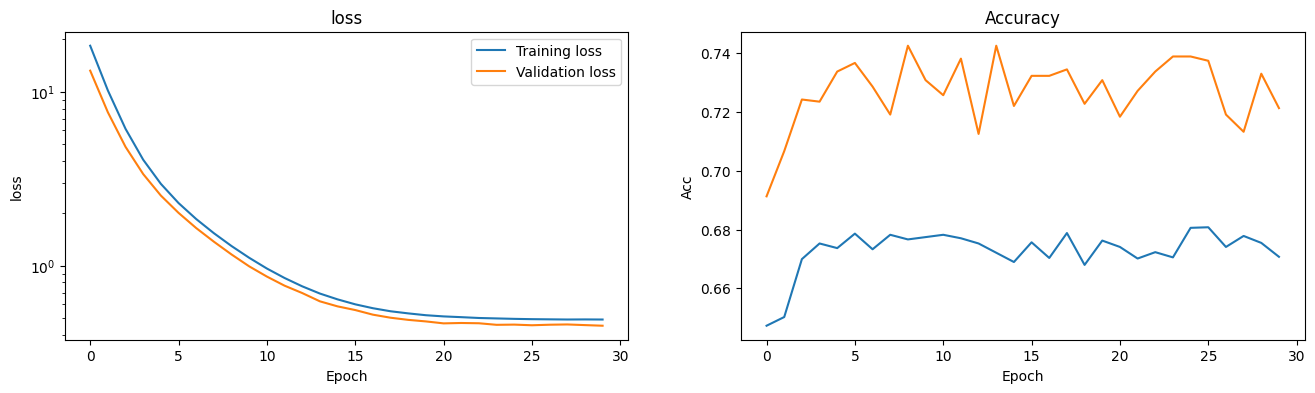

In [45]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend
#plt.savefig("SEUS_onearch.png")

In [46]:
from sklearn.metrics import classification_report
import numpy as np

y_val_pred = model.predict(X_validation)
y_val_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_validation, axis=1)

print(classification_report(y_val_true, y_val_classes, digits=3))

43/43 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0      0.735     0.932     0.822       945
           1      0.621     0.249     0.355       422

    accuracy                          0.721      1367
   macro avg      0.678     0.591     0.589      1367
weighted avg      0.700     0.721     0.678      1367



In [ ]:
# Example variables:
# y_all: shape (n_samples, 2) — one-hot encoded true labels
# pred_probs: shape (n_samples, 2) — predicted probabilities for each class

# Convert one-hot labels to 1D integer labels (0 or 1)
y_true = np.argmax(Y_test, axis=1)

# Extract predicted probability for the positive class (class 1)
y_prob = pred_test[:,1]

# Create climatology baseline: constant probability = mean positive class rate
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

# Compute Brier Scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)

# Compute Brier Skill Score
bss = 1 - (bs_model / bs_climo)

print(f"Brier Score (Model): {bs_model:.4f}")
print(f"Brier Score (Climatology): {bs_climo:.4f}")
print(f"Brier Skill Score: {bss:.4f}")

In [ ]:
## Labels for negative class
y_true_neg = 1 - y_true  # flip 0 <-> 1

# Predicted probabilities for negative class
y_prob_neg = pred_test[:, 0]

# Calculate Brier Score and BSS for negative class
bs_model_neg = brier_score_loss(y_true_neg, y_prob_neg)
bs_climo_neg = brier_score_loss(y_true_neg, np.full_like(y_true_neg, y_true_neg.mean()))
bss_neg = 1 - (bs_model_neg / bs_climo_neg)

print(f"Brier Score (Model): {bs_model_neg:.4f}")
print(f"Brier Score (Climatology): {bs_climo_neg:.4f}")
print(f"Brier Skill Score: {bss_neg:.4f}")

In [ ]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()